## Importing dependencies

In [1]:
import os
import gc
import cv2
import PIL
import random
import openslide
import skimage.io
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display
import time

from skimage.transform import rescale, resize, downscale_local_mean

from torch import cuda

import multiprocessing
from multiprocessing import Pool

import cupy as cp


In [2]:
cuda.set_device(0)
print(cuda.get_device_name(0))
cp.cuda.Device(0).use()

GeForce GTX 1060 6GB


In [3]:
# train_df = pd.read_csv('/home/terry/Downloads/fai_data/train.csv').sample(n=10, random_state=0).reset_index(drop=True)
train_df = pd.read_csv('/home/terry/Downloads/fai_data/train.csv')
images = list(train_df['image_id'])
labels = list(train_df['isup_grade'])
test_df = pd.read_csv('/home/terry/Downloads/fai_data/test.csv')
test_images = list(test_df['image_id'])



In [4]:
data_dir = '/home/terry/Downloads/fai_data/train_images/'

## Compute statistics

First we need to write a function to compute the proportion of white pixels in the region.

In [5]:
def compute_statistics(image):
    """
    Args:
        image                  numpy.array   multi-dimensional array of the form WxHxC
    
    Returns:
        ratio_white_pixels     float         ratio of white pixels over total pixels in the image 
    """
    width, height = image.shape[0], image.shape[1]
    num_pixels = width * height
    
    num_white_pixels = 0
    
    summed_matrix = np.sum(image, axis=-1)
    # Note: A 3-channel white pixel has RGB (255, 255, 255)
    num_white_pixels = np.count_nonzero(summed_matrix > 620)
    ratio_white_pixels = num_white_pixels / num_pixels
    
    green_concentration = np.mean(image[1])
    blue_concentration = np.mean(image[2])
    
    return ratio_white_pixels, green_concentration, blue_concentration

## Select k-best regions

Then we need a function to sort a list of tuples, where one component of the tuple is the proportion of white pixels in the regions. We are sorting in ascending order.

In [6]:
def select_k_best_regions(regions, k=9):
    """
    Args:
        regions               list           list of 2-component tuples first component the region, 
                                             second component the ratio of white pixels
                                             
        k                     int            number of regions to select
    """
    regions = [x for x in regions if x[3] > 180 and x[4] > 180]
    k_best_regions = sorted(regions, key=lambda tup: tup[2])[:k]
    return k_best_regions

Since we will only store, the coordinates of the top-left pixel, we need a way to retrieve the k best regions, hence the function hereafter...

In [7]:
def get_k_best_regions(coordinates, image, window_size=512):
    regions = {}
    for i, tup in enumerate(coordinates):
        x, y = tup[0], tup[1]
        regions[i] = image[x : x+window_size, y : y+window_size, :]
    
    return regions

## Slide over the image

The main function: the two while loops slide over the image (the first one from top to bottom, the second from left to right). The order does not matter actually.
Then you select the region, compute the statistics of that region, sort the array and select the k-best regions.

In [8]:
def generate_patches(slide_path, window_size=256, stride=120, k=9):
    
    print(skimage.io.MultiImage(slide_path))
    # help(skimage.io.MultiImage)
    image = skimage.io.MultiImage(slide_path)[-2]
    
    image = np.array(image)
    
    max_width, max_height = image.shape[0], image.shape[1]
    regions_container = []
    i = 0
    
    while window_size + stride*i <= max_height:
        j = 0
        
        while window_size + stride*j <= max_width:            
            x_top_left_pixel = j * stride
            y_top_left_pixel = i * stride
            
            patch = image[
                x_top_left_pixel : x_top_left_pixel + window_size,
                y_top_left_pixel : y_top_left_pixel + window_size,
                :
            ]
            
            ratio_white_pixels, green_concentration, blue_concentration = compute_statistics(patch)
            
            region_tuple = (x_top_left_pixel, y_top_left_pixel, ratio_white_pixels, green_concentration, blue_concentration)
            regions_container.append(region_tuple)
            
            j += 1
        
        i += 1
    
    k_best_region_coordinates = select_k_best_regions(regions_container, k=k)
    k_best_regions = get_k_best_regions(k_best_region_coordinates, image, window_size)
    
    return image, k_best_region_coordinates, k_best_regions

## Show the results

In [9]:
def display_images(regions, title):
    fig, ax = plt.subplots(5, 4, figsize=(15, 15))
    
    for i, region in regions.items():
        ax[i//4, i%4].imshow(region)
    
    fig.suptitle(title)

Now we will show some results. 

Please note:
1. The smaller the window size, the more precise but the longer.
2. I would say that a window size of around 200 is a good choice. It is a good trade-off between generality, having enough of the biopsy structure captured as well as enough details.
3. A too small window size might harm the performance of the model since you might select only a tiny portion of the biopsy. (To counter this, introducing a random choice might be worth trying).

### Window size: 200, stride: 128

In [10]:
%%time

ex_url = data_dir + images[0] + '.tiff'
_, best_coordinates, best_regions = generate_patches(ex_url)

['/home/terry/Downloads/fai_data/train_images/0005f7aaab2800f6170c399693a96917.tiff']
CPU times: user 3.32 s, sys: 76.3 ms, total: 3.39 s
Wall time: 3.42 s


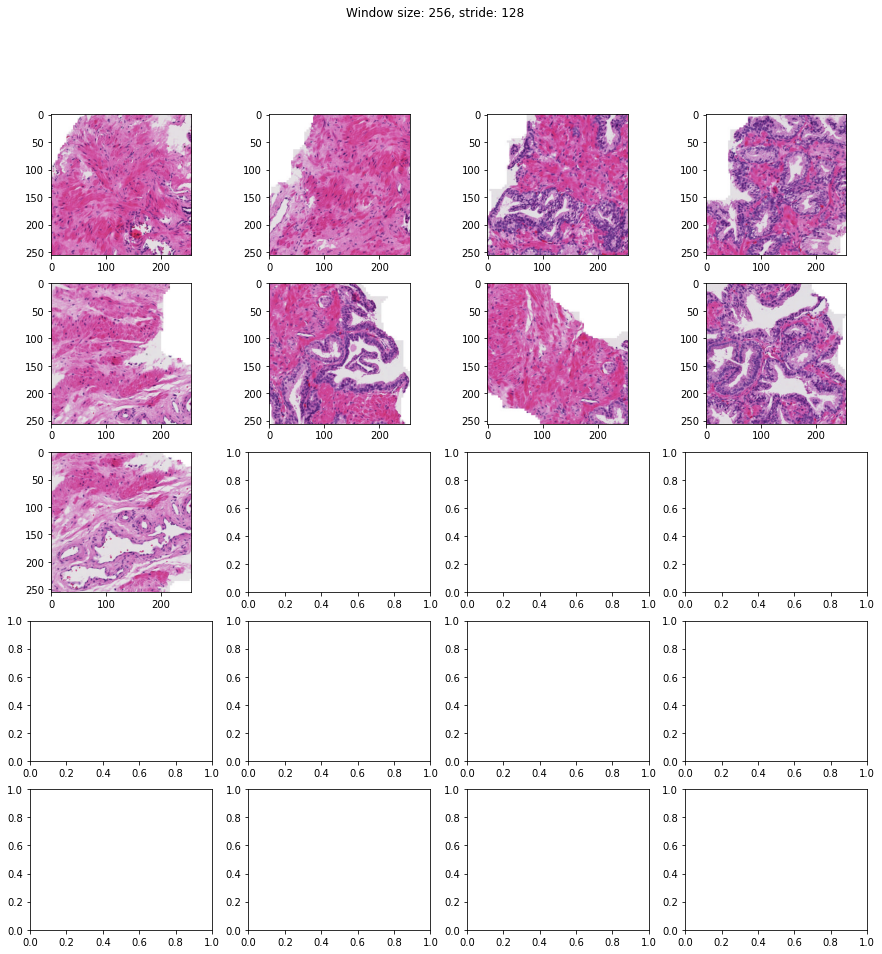

In [11]:
display_images(best_regions, 'Window size: 256, stride: 128')

### Window size: 128, stride: 64

['/home/terry/Downloads/fai_data/train_images/0005f7aaab2800f6170c399693a96917.tiff']
CPU times: user 3.11 s, sys: 96.7 ms, total: 3.2 s
Wall time: 2.96 s


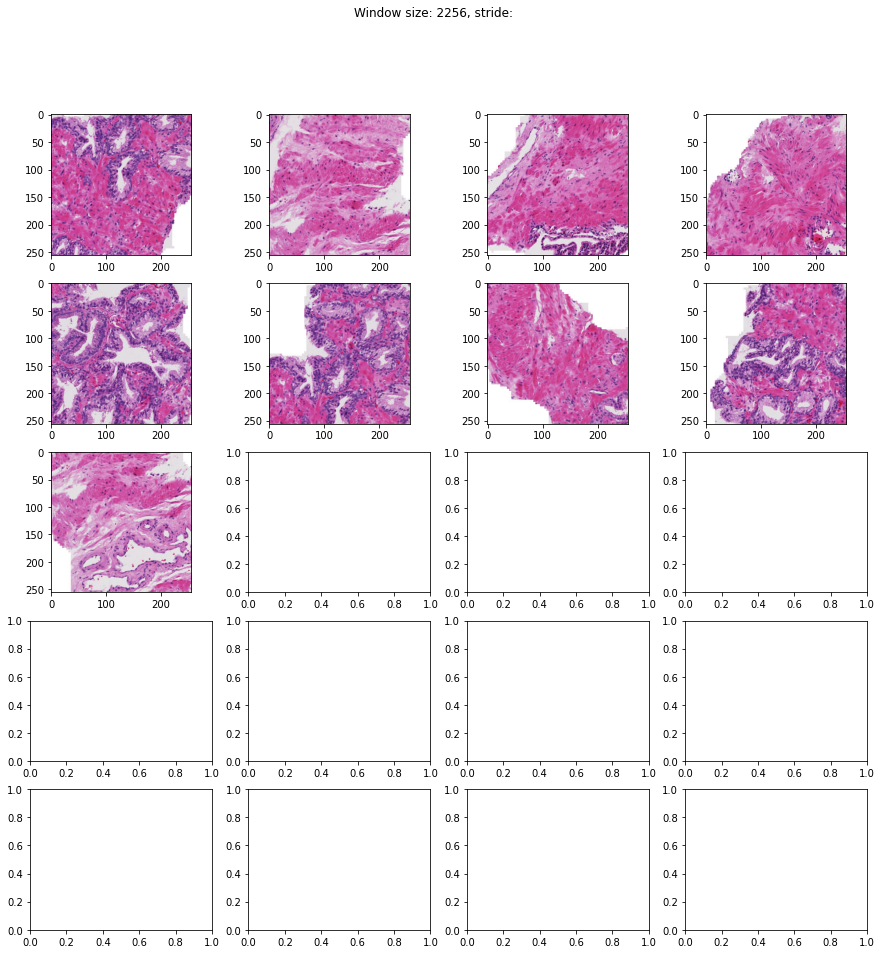

In [12]:
%%time

ex_url = data_dir + images[0] + '.tiff'
# _, best_coordinates, best_regions = generate_patches(ex_url, window_size=128, stride=64)
# display_images(best_regions, 'Window size: 128, stride: 64')
_, best_coordinates, best_regions = generate_patches(ex_url, window_size=256, stride=128)
display_images(best_regions, 'Window size: 2256, stride: ')

## Glue to one picture

In [13]:
def glue_to_one_picture(image_patches, window_size=200, k=9):
    side = int(np.sqrt(k))
    image = np.zeros((side*window_size, side*window_size, 3), dtype=np.int16)
        
    for i, patch in image_patches.items():
        x = i // side
        y = i % side
        image[
            x * window_size : (x+1) * window_size,
            y * window_size : (y+1) * window_size,
            :
        ] = patch
    
    return image

In [14]:
def crop_center(img,cropx,cropy):
    y,x,z = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx,:z]

In [15]:
def slur(image, n):

    r1, g1, b1 = 214, 214, 214 
    r2, g2, b2 = 255, 255, 255
    red, green, blue = image[n:,:,0], image[n:,:,1], image[n:,:,2]
    mask =(red >= r1) & (green >= g1) & (blue >= b1)
    image[n:,:,:3][mask] = [r2, g2, b2]
#     slurred = np.copy(image)
    slurred = cp.copy(image)
#     cp.cuda.Stream.null.synchronize()

    
    if n >= 0:
        slurred[n:,:,:3][mask] = image[:-n,:,:3][mask]
        
    del image
    del mask
    del red
    del green
    del blue
    print('.', end='')
    return slurred

In [16]:
def striplicate(npimage):
    image =np.copy(npimage)
#     image = cp.copy(npimage)
#     cp.cuda.Stream.null.synchronize()

#     help(cp.cuda.Stream.null)
    rimage = np.rot90(image, k=1)
#     rimage = cp.rot90(image, k=1)
#     cp.cuda.Stream.null.synchronize()

        
    r1, g1, b1 = 214, 214, 214 # Original value
    r2, g2, b2 = 255, 255, 255 # Value that we want to replace it with
    
   
    red, green, blue = image[:,:,0], image[:,:,1], image[:,:,2]
    rred, rgreen, rblue = rimage[:,:,0], rimage[:,:,1], rimage[:,:,2]
    
    mask = (red >= r1) & (green >= g1) & (blue >= b1)
    rmask =(rred >= r1) & (rgreen >= g1) & (rblue >= b1)
        
    rimage[:,:,:3][rmask] = [r2, g2, b2]
    del rmask
    rows,cols,depth = rimage.shape

    stripe_size = cols//6
    simage = None
    for stripe in range(stripe_size, cols, stripe_size):
        # print(f'stripe: {stripe}, cols: {cols}')
        if simage is not None:
            simage = slur(simage, stripe_size)
        else:
            simage = slur(rimage, stripe_size)
            del rimage
            
    stripe_size = cols//3
    
    simage = np.rot90(simage, k=1)
#     simage = cp.rot90(simage, k=1)
#     cp.cuda.Stream.null.synchronize()

    for stripe in range(stripe_size, cols, stripe_size):
        # print(f'stripe: {stripe}, cols: {cols}')
        if simage is not None:
            simage = slur(simage, stripe_size)
        else:
            simage = slur(rimage, stripe_size)
            del rimage
            
    stripe_size = cols//2      
    simage = np.rot90(simage, k=1)
#     simage = cp.rot90(simage, k=1)
#     cp.cuda.Stream.null.synchronize()

    for stripe in range(stripe_size, cols, stripe_size):
        # print(f'stripe: {stripe}, cols: {cols}')
        if simage is not None:
            simage = slur(simage, stripe_size)
        else:
            simage = slur(rimage, stripe_size)
            del rimage
    
    stripe_size = cols//2
    simage = np.rot90(simage, k=1)
#     simage = cp.rot90(simage, k=1)
#     cp.cuda.Stream.null.synchronize()
    for stripe in range(stripe_size, cols, stripe_size):
        # print(f'stripe: {stripe}, cols: {cols}')
        if simage is not None:
            simage = slur(simage, stripe_size)
        else:
            simage = slur(rimage, stripe_size)
            del rimage

    stripe_size = cols//2
    simage = np.rot90(simage, k=1)
#     simage = cp.rot90(simage, k=1)
#     cp.cuda.Stream.null.synchronize()

    for stripe in range(stripe_size, cols, stripe_size):
        # print(f'stripe: {stripe}, cols: {cols}')
        if simage is not None:
            simage = slur(simage, stripe_size)
        else:
            simage = slur(rimage, stripe_size)
            del rimage

            
    print(f'simage shape: {simage.shape}')


    image[:,:,:3][mask] = [r2, g2, b2]
    image[:,:,:3][mask] = simage[:,:,:3][mask]

    return image
#     return crop_center(image, 2048, 2048)

In [17]:
WINDOW_SIZE = 256
STRIDE = 128
K = 25

In [18]:
# # for counter, img in enumerate(images[:3]):
# for counter, img in enumerate(images):
# #     if counter > 2:
# #         continue

#     if counter < 0 or counter > 11000:
#         continue
    
#     fig, ax = plt.subplots(6, 2, figsize=(20, 25))

#     url = data_dir + img + '.tiff'
#     print(url)  File "<ipython-input-19-9748071ab0f5>", line 21, in process_images

        
#     image, best_coordinates, best_regions = generate_patches(url, window_size=WINDOW_SIZE, stride=STRIDE, k=K)
        
#     glued_image = glue_to_one_picture(best_regions, window_size=WINDOW_SIZE, k=K)
#     simage = striplicate(glued_image)
#     npImage = np.array(simage, dtype=np.uint8)

#     plt.imsave(f'/home/terry/Downloads/fai_data/glue_twist1/{img}.jpeg', npImage, format='jpg')
#     plt.close()
#     del npImage
#     del glued_image
#     del fig
#     del ax
#     del best_coordinates
#     del best_regions
#     gc.collect()
        


In [19]:
def process_images(range_list):
    print(f'range_list: {range_list}')
    starting_index, ending_index = range_list

    for counter, img in enumerate(images):
        #     if counter > 0:
        #         continue
        img_file = f'/home/terry/Downloads/fai_data/tile_strip2/{img}.jpeg'
        if counter < starting_index or counter > ending_index or os.path.isfile(img_file):
            continue
     
        fig, ax = plt.subplots(6, 2, figsize=(20, 25))
        print(img)
        url = data_dir + img + '.tiff'
        print(url)
        
        image, best_coordinates, best_regions = generate_patches(
            url, window_size=WINDOW_SIZE, stride=STRIDE, k=K)
        
        glued_image = glue_to_one_picture(best_regions, window_size=WINDOW_SIZE, k=K)
        simage = striplicate(np.array(glued_image, dtype=np.uint8))
        npImage = np.array(simage, dtype=np.uint8)

        plt.imsave(img_file, npImage, format='jpg')
        plt.close()
        del npImage
        del glued_image
        del fig
        del ax
        del best_coordinates
        del best_regions
        gc.collect()
        
 

In [20]:
# # # for counter, img in enumerate(images[:3]):
# for counter, img in enumerate(images):
# #     if counter > 2:
# #         continue

#     if counter < 0 or counter > 11000:
#         continue
    
#     fig, ax = plt.subplots(6, 2, figsize=(20, 25))

#     url = data_dir + img + '.tiff'
#     print(url)
        
#     image, best_coordinates, best_regions = generate_patches(url, window_size=WINDOW_SIZE, stride=STRIDE, k=K)
        
#     glued_image = glue_to_one_picture(best_regions, window_size=WINDOW_SIZE, k=K)
#     simage = striplicate(glued_image)
#     npImage = np.array(simage, dtype=np.uint8)

#     plt.imsave(f'/home/terry/Downloads/fai_data/glue_twist1/{img}.jpeg', npImage, format='jpg')
#     plt.close()
#     del npImage
#     del glued_image
#     del fig
#     del ax
#     del best_coordinates
#     del best_regions
#     gc.collect()
        

In [21]:
nprocs=2
end=10620
group_len = end//nprocs
start=0
# multiprocessing.set_start_method('spawn')
# ctx = multiprocessing.get_context('spawn')
multiprocessing.set_start_method('fork')

     
# fig, ax = plt.subplots(6, 2, figsize=(20, 25))


range_list = list()

for i in range(1,nprocs+1):
    end = group_len * i
    range_list.append([start, end])
    start = end

with Pool(nprocs) as workers:
    w = list(workers.map(process_images, range_list))
    print(w)

range_list: [0, 5310]
range_list: [5310, 10620]
ffcd99c47e57ad2934dc6bbf5edf6675
/home/terry/Downloads/fai_data/train_images/ffcd99c47e57ad2934dc6bbf5edf6675.tiff
['/home/terry/Downloads/fai_data/train_images/ffcd99c47e57ad2934dc6bbf5edf6675.tiff']
............simage shape: (1280, 1280, 3)
ffcee00fd033d3ece1408035a7fd4ea7
/home/terry/Downloads/fai_data/train_images/ffcee00fd033d3ece1408035a7fd4ea7.tiff
['/home/terry/Downloads/fai_data/train_images/ffcee00fd033d3ece1408035a7fd4ea7.tiff']
............simage shape: (1280, 1280, 3)
ffd2841373b39792ab0c84cccd066e31
/home/terry/Downloads/fai_data/train_images/ffd2841373b39792ab0c84cccd066e31.tiff
['/home/terry/Downloads/fai_data/train_images/ffd2841373b39792ab0c84cccd066e31.tiff']
............simage shape: (1280, 1280, 3)
ffdc59cd580a1468eac0e6a32dd1ff2d
/home/terry/Downloads/fai_data/train_images/ffdc59cd580a1468eac0e6a32dd1ff2d.tiff
['/home/terry/Downloads/fai_data/train_images/ffdc59cd580a1468eac0e6a32dd1ff2d.tiff']
............simage sha